In [183]:
# %matplotlib ipympl

In [184]:
import torch
import numpy as np
import importlib
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
from mpl_toolkits.mplot3d import Axes3D
import seaborn as sns
from time import sleep, time
import sys
import os
DatasetPath = '../../../CDEs/Dataset/' 
# append absolute DasetPath to path
DatasetPath = os.path.abspath(DatasetPath)
sys.path.append(DatasetPath)
import Dataset2 as DS

import pandas as pd
from scipy.optimize import curve_fit

importlib.reload(DS)
DatasetContainer = DS.DatasetContainer
ProcessingDatasetContainer = DS.ProcessingDatasetContainer

def PLTParams(figsize = [10,10]):
    plt.rcParams['figure.figsize']=figsize
    plt.rcParams['font.size']=15
PLTParams()

# Add the ignore warnings
import warnings
warnings.filterwarnings("ignore")

hostname = os.uname()
if 'tedtop' in hostname: plt.style.use('/home/fedor-tairli/work/MPLStylefiles/Vscode_DarkModern_Invisible.mplstyle')

plt.style.use('default')


In [185]:
def IndexToXY(indices,return_tensor=False):
    indices = indices -1
    Xs = indices//22
    Ys = indices%22
    if return_tensor: return Xs.int(),Ys.int()
    else:             return Xs.int().tolist(),Ys.int().tolist()



#### Import Datasets

In [186]:
DataPath = '/remote/tychodata/ftairli/data/Simulations__libraries__MCTask__Offline_v3r99p2a__IdealMC_CORSIKA__Hybrid_CORSIKA76400/SIB23c/DatasetFiles/RawData'
print('DataPath:',DataPath)

DataPath: /remote/tychodata/ftairli/data/Simulations__libraries__MCTask__Offline_v3r99p2a__IdealMC_CORSIKA__Hybrid_CORSIKA76400/SIB23c/DatasetFiles/RawData


In [187]:
# Importing Dataset
# Cause it takes a while to lad this thing introduce a check if its already laoded into globals
CheckGlobals = True 
LoadTraces = True

RunsToLoad = ['Run010']
# RunsToLoad = ['Run010','Run030','Run080','Run090']

if CheckGlobals: 
    if 'Dataset' in globals():
        print('Dataset already loaded')
        if len(Dataset.Event_level_keys.keys())<1: # pyright: ignore[reportUndefinedVariable]
            print('Dataset Event_level_keys is None, reloading Dataset')
            Dataset.Load(DataPath,RunsToLoad ,LoadTraces=LoadTraces) # pyright: ignore[reportUndefinedVariable]
    else:
        print('Loading Dataset')
        Dataset = DatasetContainer()
        Dataset.Load(DataPath,RunsToLoad ,LoadTraces=LoadTraces)

# Unfuck the Dataset Keys, cuase the EventID string should have a capital D....
if 'EventId_1/2' in Dataset.Event_level_keys.keys(): # pyright: ignore[reportPossiblyUnboundVariable]
    Dataset.Event_level_keys['EventID_1/2'] = Dataset.Event_level_keys.pop('EventId_1/2') # type: ignore
    Dataset.Event_level_keys['EventID_2/2'] = Dataset.Event_level_keys.pop('EventId_2/2') # pyright: ignore[reportPossiblyUnboundVariable]
    print('Replaced the EventID Keys, with proper ones')
else:
    print('EventID Keys already replaced')

Dataset already loaded
EventID Keys already replaced


In [188]:
print('Event level keys:')
for key in Dataset.Event_level_keys.keys(): print('    ',key)
print('Pixel level keys:')
for key in Dataset.Pixel_level_keys.keys(): print('    ',key)

Event level keys:
     EventID_1/2
     EventID_2/2
     Primary
     Station_TotalSignal
     Station_Time
     Station_Theta
     Station_Phi
     Station_Distance
     Station_Chi_i
     Gen_LogE
     Gen_CosZenith
     Gen_Xmax
     Gen_dEdXmax
     Rec_LogE
     Rec_CosZenith
     Rec_Xmax
     Rec_dEdXmax
     Rec_UspL
     Rec_UspR
     Gen_SDPPhi
     Gen_SDPTheta
     Gen_Chi0
     Gen_Rp
     Gen_T0
     Gen_CoreEyeDist
     Rec_SDPPhi
     Rec_SDPTheta
     Rec_Chi0
     Rec_Rp
     Rec_T0
     Rec_CoreEyeDist
Pixel level keys:
     PixelID
     TelID
     EyeID
     Status
     Charge
     Chi_i
     Theta
     Phi
     TimeOffset
     PulseStart
     PulseCentroid
     PulseStop


In [189]:
The_path_to_camera_view_table = '../../../CDEs/ReadingData/camera_view_table_with_HEAT_down.txt'

AllPossiblePixelDirections = pd.read_csv(The_path_to_camera_view_table,sep=' ',header=None,names = ['EyeID','TelID','PixID','Theta','Phi'])

In [190]:
AllPossiblePixelDirections.head()

,EyeID,TelID,PixID,Theta,Phi
0,1,1,1,1.61140,358.419
1,1,1,2,2.86980,359.174
2,1,1,3,4.13764,358.434
3,1,1,4,5.38773,359.205
4,1,1,5,6.66357,358.476


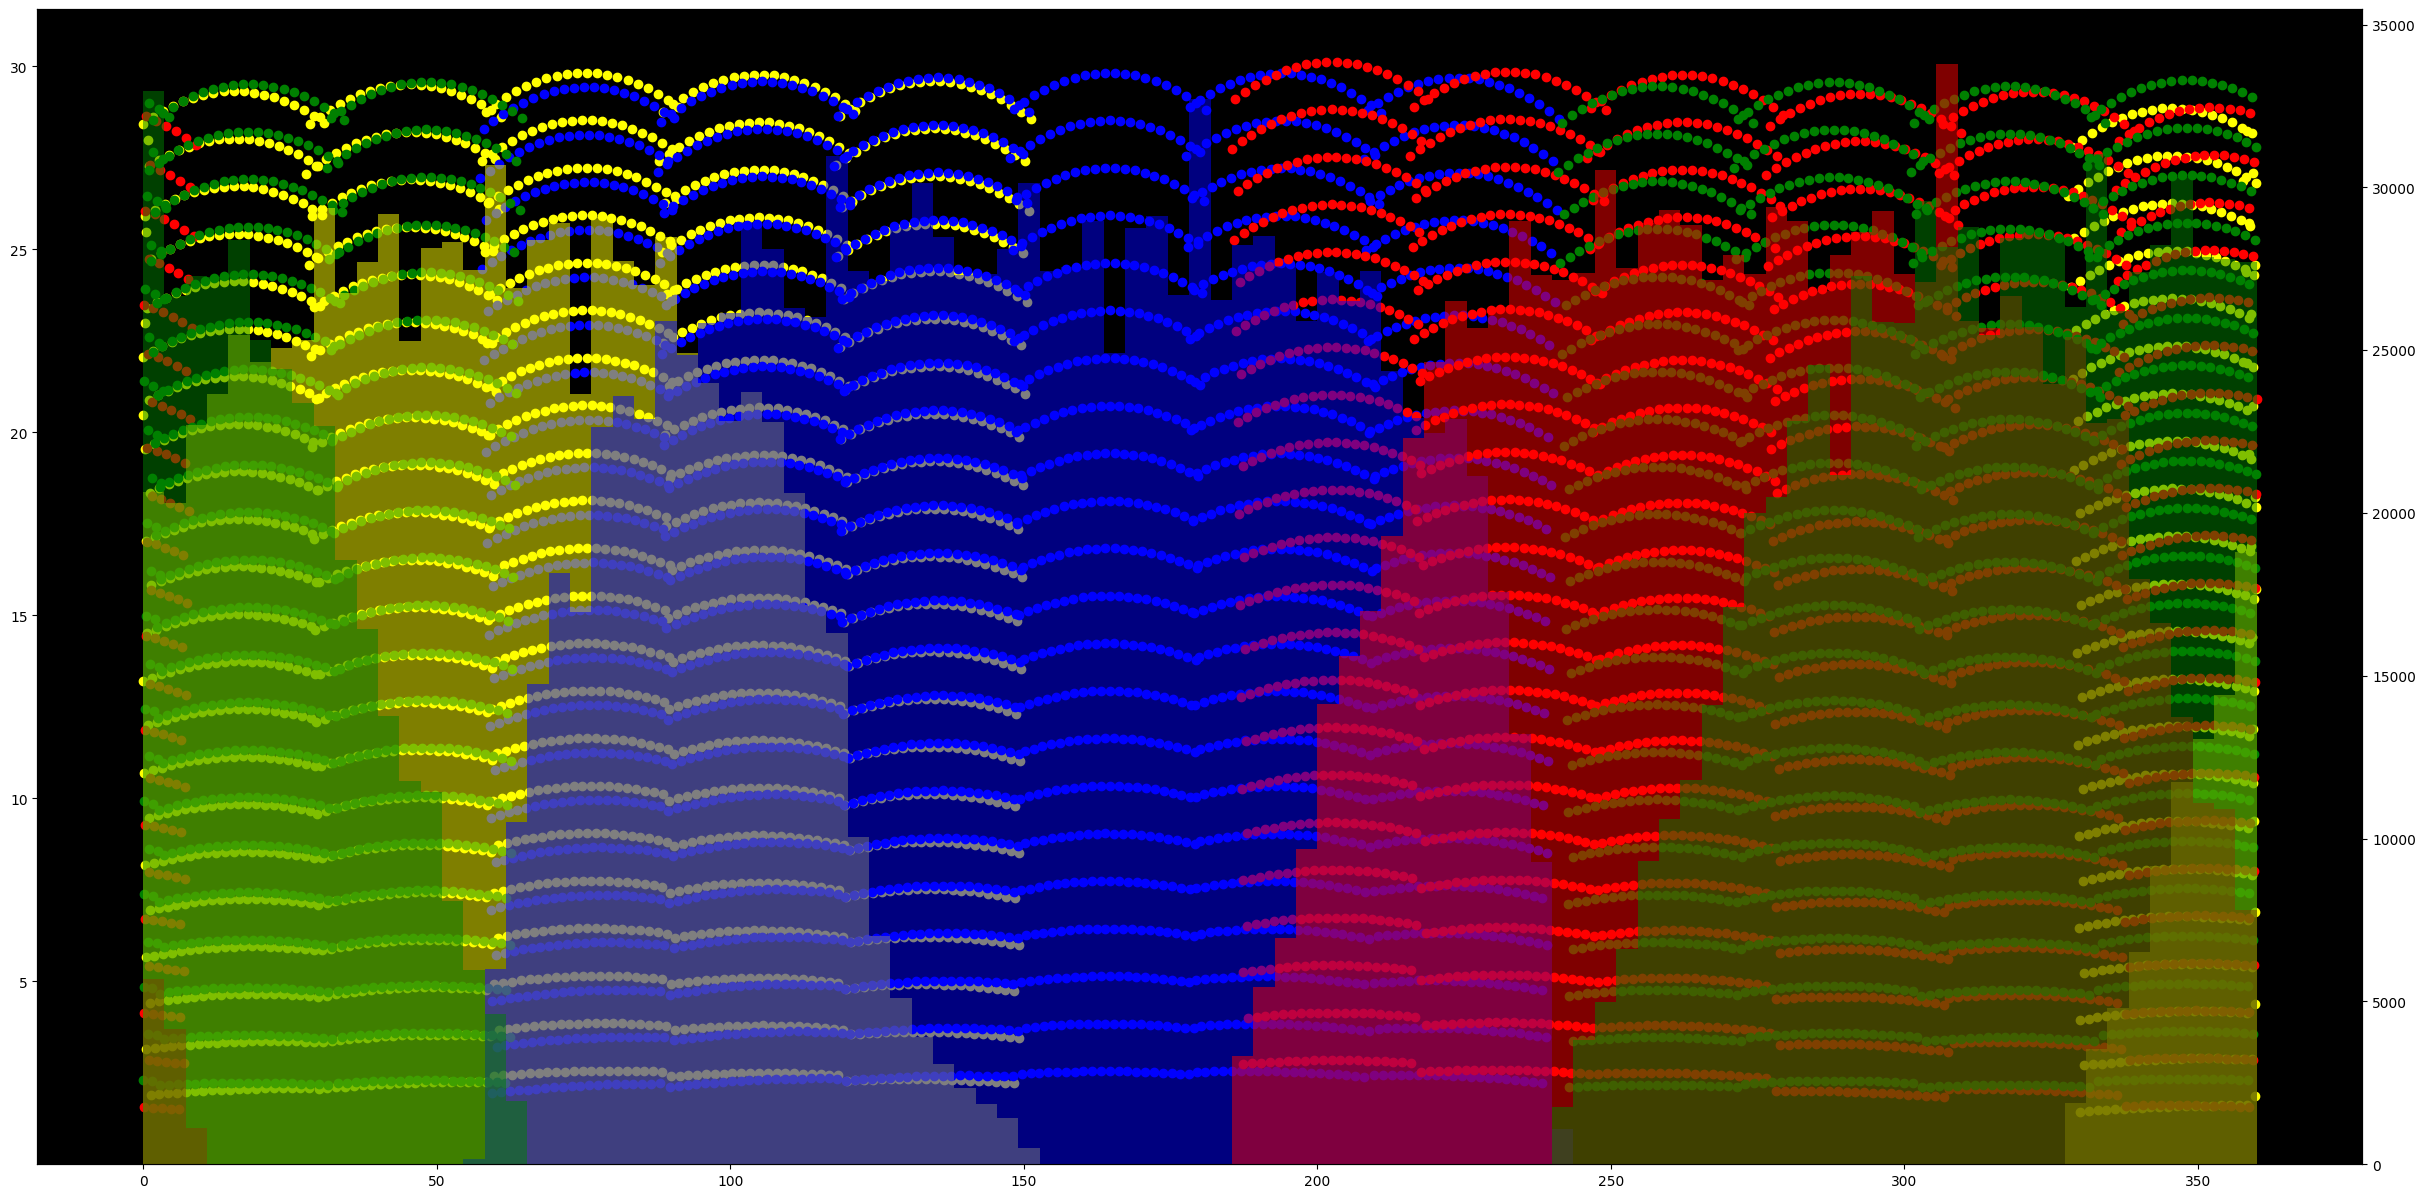

In [191]:
colors = ['yellow','blue','red','green','cyan']
plt.figure(figsize = (30,15))
plt.gca().set_facecolor('black')
for iEye in range(1,5):
    Mask = AllPossiblePixelDirections.EyeID == iEye
    Thetas = AllPossiblePixelDirections.Theta[Mask]
    Phis   = AllPossiblePixelDirections.Phi[Mask]
    plt.scatter(Phis,Thetas,c = colors[iEye-1])
    

Backwall_angles = [330,60,188,243.0219]

ax2 = plt.gca().twinx()
bins = np.linspace(0,360,100)

all_EyeIDs = Dataset.get_pixel_values('EyeID').numpy()
AllThetas = Dataset.get_pixel_values('Theta').numpy()
AllPhis   = Dataset.get_pixel_values('Phi').numpy()
for iEye in range(1,5):
    Mask = all_EyeIDs == iEye
    Thetas = AllThetas[Mask]
    Phis   = AllPhis[Mask]
    X = (Phis + Backwall_angles[iEye-1])%360

    ax2.hist(X,bins=bins,alpha=0.5,label=f'EyeID={iEye}',color = colors[iEye-1])


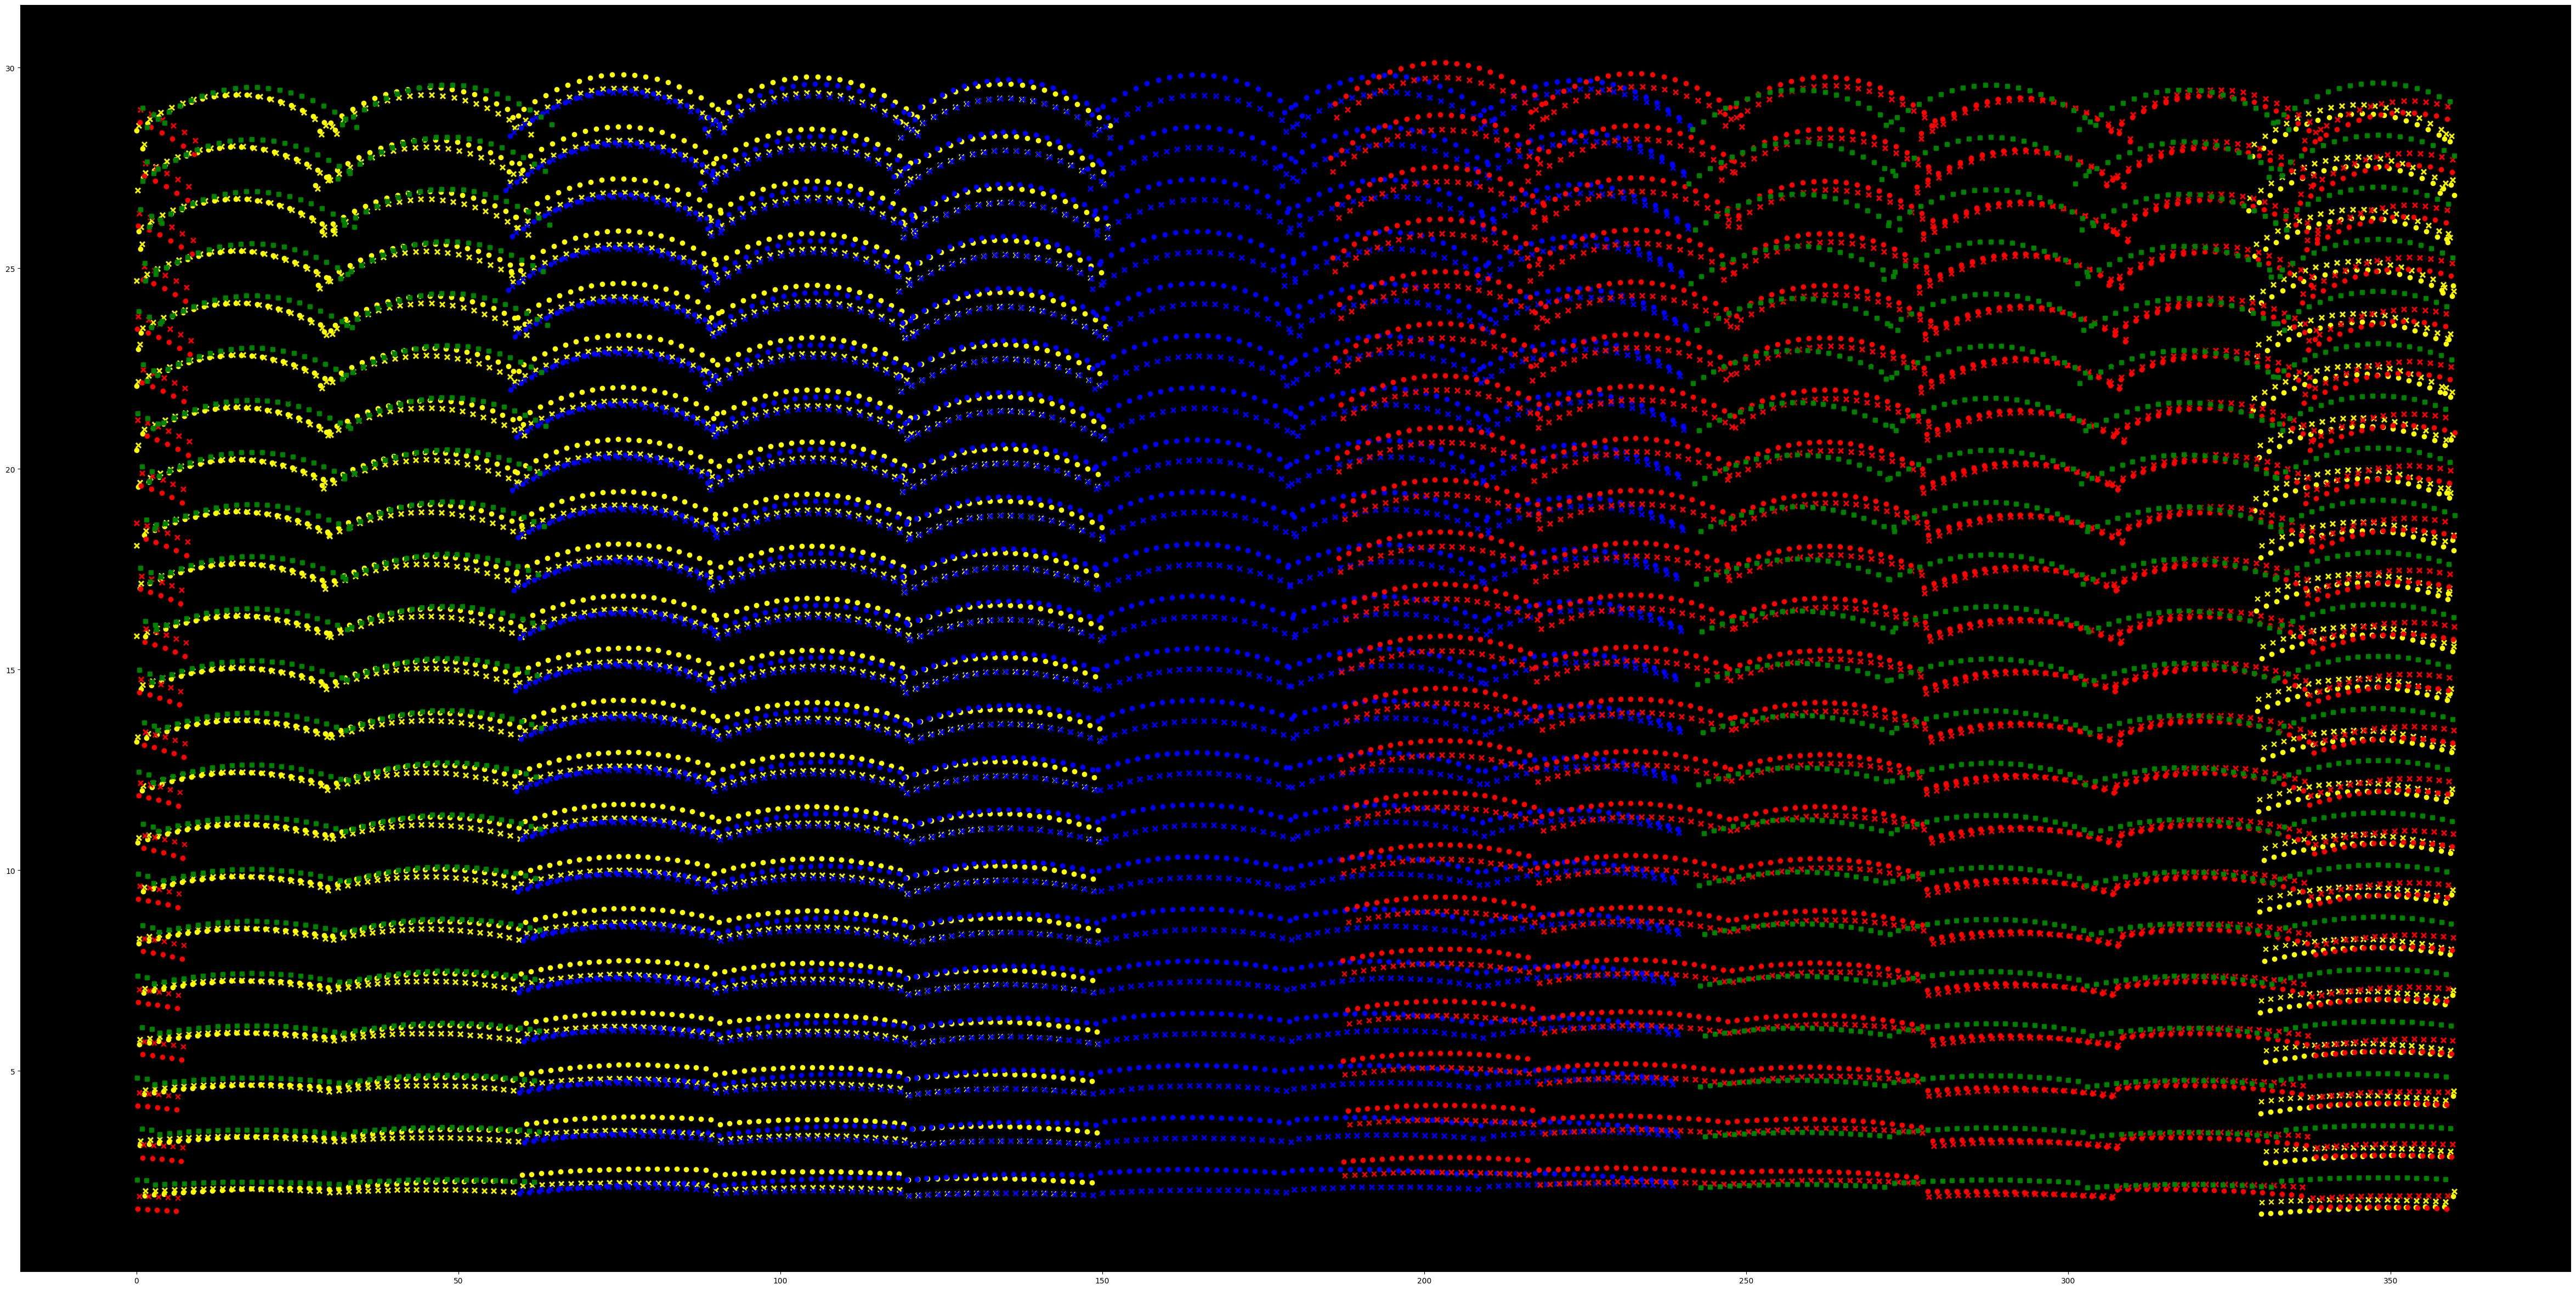

In [192]:
colors = ['yellow','blue','red','green','cyan']
plt.figure(figsize = (60,30))
plt.gca().set_facecolor('black')
Backwall_angles = [330,60,188,243.0219]
bins = np.linspace(0,360,100)

all_EyeIDs = Dataset.get_pixel_values('EyeID').numpy()
AllThetas = 90-Dataset.get_pixel_values('Theta').numpy()
AllPhis   = Dataset.get_pixel_values('Phi').numpy()

for iEye in range(1,5):
    Mask = AllPossiblePixelDirections.EyeID == iEye
    Thetas = AllPossiblePixelDirections.Theta[Mask]
    Phis   = AllPossiblePixelDirections.Phi[Mask]
    plt.scatter(Phis,Thetas,c = colors[iEye-1])
    


    # ax2 = plt.gca().twinx()

    Mask = all_EyeIDs == iEye
    Thetas = AllThetas[Mask]
    Phis   = AllPhis[Mask]
    X = (Phis + Backwall_angles[iEye-1])%360
    Y = Thetas
    plt.scatter(X,Y,alpha=0.1,label=f'EyeID={iEye}',color = colors[iEye-1],marker='x')
plt.savefig('CameraView_vs_RealData.png')

In [193]:
# Find Random Event
Event_Found = False

while not Event_Found:
    RandomEventIndex = np.random.randint(len(Dataset))
    print('RandomEventIndex:',RandomEventIndex)
    Event = Dataset.get_event_by_index(RandomEventIndex)

    All_Tel_IDs = Event.get_pixel_values('TelID').unique()
    if len(All_Tel_IDs)<2:
        print('Event has less than 2 telescopes. Great')
        Event_Found = True





RandomEventIndex: 123197
RandomEventIndex: 42518
RandomEventIndex: 81519
Event has less than 2 telescopes. Great


RandomEventIndex: 147760
Event has less than 2 telescopes. Great
Event has only 1 EyeID
The_Eye_ID: 3.0
The_Tel_ID: 4.0
Gen_SDP_Theta: 73.09647959180136
Gen_SDP_Phi  : -162.67268934884774


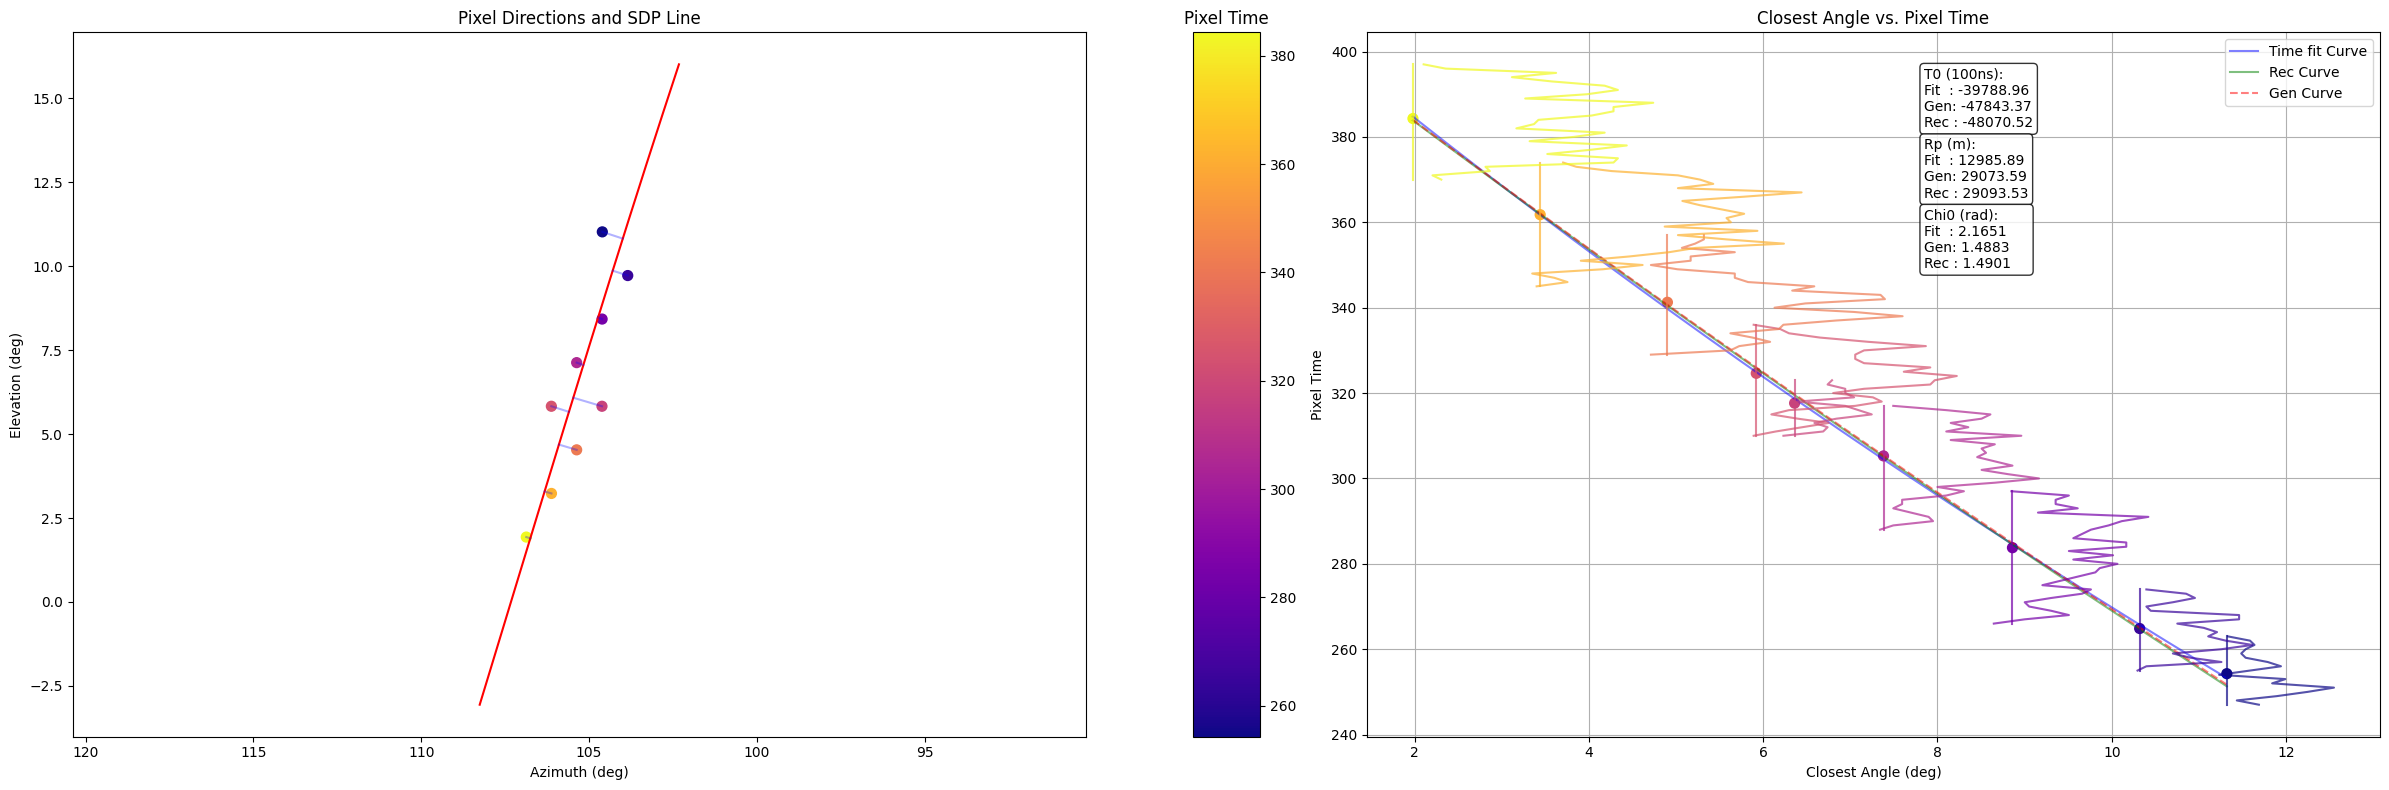

In [220]:
# Find Random Event
from IPython.display import clear_output


Event_Found = False
Nattempts = 0

while not Event_Found:
    RandomEventIndex = np.random.randint(len(Dataset))
    print('RandomEventIndex:',RandomEventIndex)
    Event = Dataset.get_event_by_index(RandomEventIndex)

    All_Tel_IDs = Event.get_pixel_values('TelID').unique()
    if len(All_Tel_IDs)<2:
        print('Event has less than 2 telescopes. Great')
        Event_Found = True
    else:
        continue


    try:


        All_Eye_IDs = Event.get_pixel_values('EyeID').unique()
        All_Tel_IDs = Event.get_pixel_values('TelID')
        if len( All_Eye_IDs )>1: 
            print('Event has more than 1 EyeID!')
        else:
            print('Event has only 1 EyeID')
            The_Eye_ID = All_Eye_IDs[0].item()
            The_Tel_ID = All_Tel_IDs.unique()[0].item()

        print('The_Eye_ID:',The_Eye_ID)
        print('The_Tel_ID:',The_Tel_ID)


        Gen_SDP_Theta = Event.get_value('Gen_SDPTheta').item() 
        Gen_SDP_Phi   = Event.get_value('Gen_SDPPhi'  ).item()

        print('Gen_SDP_Theta:',Gen_SDP_Theta*180/np.pi)
        print('Gen_SDP_Phi  :',Gen_SDP_Phi  *180/np.pi)


        SDP_Vec = np.array(
            [ np.sin(Gen_SDP_Theta)*np.cos(Gen_SDP_Phi),
                np.sin(Gen_SDP_Theta)*np.sin(Gen_SDP_Phi),
                np.cos(Gen_SDP_Theta)

            ]
        )
        SDP_Vec = SDP_Vec/np.linalg.norm(SDP_Vec)

        SDP_Orth = np.cross(SDP_Vec,np.array([0,0,1])) if not (SDP_Vec==np.array([0,0,1])).all() else np.array([1,0,0])
        SDP_Orth = SDP_Orth/np.linalg.norm(SDP_Orth)

        angles = np.linspace(0,2*np.pi,18000)

        directions = np.outer(np.cos(angles),SDP_Orth) + np.outer(np.sin(angles),np.cross(SDP_Vec,SDP_Orth))
        directions = directions/np.linalg.norm(directions,axis=1)[:,None]

        sdp_azimuths = np.rad2deg(np.arctan2(directions[:,1],directions[:,0]))
        sdp_elevations  = np.rad2deg(np.arcsin(directions[:,2]))













        # Plotting here

        TelescopePixelDirections = AllPossiblePixelDirections[ (AllPossiblePixelDirections['EyeID']==The_Eye_ID) & (AllPossiblePixelDirections['TelID']==The_Tel_ID) ]



        pix_IDs = Event.get_pixel_values('PixelID')
        pix_thetas = TelescopePixelDirections[ TelescopePixelDirections['PixID'].isin(pix_IDs.tolist()) ]['Theta']
        pix_phis   = TelescopePixelDirections[ TelescopePixelDirections['PixID'].isin(pix_IDs.tolist()) ]['Phi']

        pix_act_thetas = 90- Event.get_pixel_values('Theta')
        pix_act_phis   = Event.get_pixel_values('Phi')


        pix_charges = Event.get_pixel_values('Charge')
        pix_times   = Event.get_pixel_values('PulseCentroid')

        pix_status = Event.get_pixel_values('Status')
        status_mask = pix_status>=4
        pix_act_phis = pix_act_phis[status_mask]
        pix_act_thetas = pix_act_thetas[status_mask]
        pix_times = pix_times[status_mask]

        # if torch.max(pix_times)-torch.min(pix_times)<500:
        #     print('Event has too small time spread, skipping')
        #     Event_Found = False
        #     clear_output()
        #     continue

        # azimuth_limits = plt.gca().get_xlim()
        # elevation_limits = plt.gca().get_ylim()
        min_azimuth   = torch.min(pix_act_phis).item()
        max_azimuth   = torch.max(pix_act_phis).item()
        min_elevation = torch.min(pix_act_thetas).item()
        max_elevation = torch.max(pix_act_thetas).item()

        mask = (sdp_azimuths>=min_azimuth-5) & (sdp_azimuths<=max_azimuth+5) & (sdp_elevations>=min_elevation-5) & (sdp_elevations<=max_elevation+5)
        sdp_azimuths = sdp_azimuths[mask]
        sdp_elevations = sdp_elevations[mask]

        # Sort by increasing azimuth
        sort_indices = np.argsort(sdp_azimuths)
        sdp_azimuths = sdp_azimuths[sort_indices]
        sdp_elevations = sdp_elevations[sort_indices]




        # for every pixel, find the closest point on the sdp line
        closest_azimuths   = []
        closest_elevations = []
        closest_distances  = []
        for i in range(len(pix_act_phis)):
            pix_azimuth = pix_act_phis[i].item()
            pix_elevation = pix_act_thetas[i].item()

            dists = np.sqrt( (sdp_azimuths - pix_azimuth)**2 + (sdp_elevations - pix_elevation)**2 )
            min_index = np.argmin(dists)

            closest_sdp_azimuth = sdp_azimuths[min_index]
            closest_sdp_elevation = sdp_elevations[min_index]

            

            closest_azimuths  .append(closest_sdp_azimuth  )
            closest_elevations.append(closest_sdp_elevation)
            closest_distances .append(dists[min_index]     )


        # Now compute the angle between the pixel's closest azimuth/elevation and the SDP_Orth vector in the SDP_Vec plane
            

        closest_angles = []
        

        for i in range(len(closest_azimuths)):
            azimuth = closest_azimuths[i]
            elevation = closest_elevations[i]

            vec = np.array(
                [ np.cos(np.deg2rad(elevation))*np.cos(np.deg2rad(azimuth)),
                    np.cos(np.deg2rad(elevation))*np.sin(np.deg2rad(azimuth)),
                    np.sin(np.deg2rad(elevation))
                ]
            )
            vec = vec/np.linalg.norm(vec)

            proj_onto_sdp_vec = np.dot(vec,SDP_Vec)*SDP_Vec
            proj_onto_sdp_orth = vec - proj_onto_sdp_vec
            proj_onto_sdp_orth = proj_onto_sdp_orth/np.linalg.norm(proj_onto_sdp_orth)

            angle = np.arccos( np.clip( np.dot(proj_onto_sdp_orth,SDP_Orth), -1.0, 1.0) )
            angle_deg = np.rad2deg(angle)

            # Determine the sign of the angle using cross product
            cross_prod = np.cross(SDP_Orth, proj_onto_sdp_orth)
            
            closest_angles.append(angle_deg)


        def Time_Fit_Func(chi_i,T0,Rp,Chi_0):
            c = 299792458 # m/s
            return T0 + (Rp/c)*np.tan((Chi_0 - chi_i)/2)

        Times_for_fit = pix_times.numpy() * (100*1e-9) 
        Colsest_angles_for_fit = np.deg2rad(closest_angles)


        Gen_T0  = Event.get_value('Gen_T0').item()
        Gen_Rp  = Event.get_value('Gen_Rp').item()
        Gen_Chi0 = Event.get_value('Gen_Chi0').item()

        p0 = [-12000,16000,1.6]
        # p0 = [Gen_T0,Gen_Rp,Gen_Chi0]
        popt, pcov = curve_fit(Time_Fit_Func, Colsest_angles_for_fit, Times_for_fit, p0=p0,maxfev = 100000)


        plot_angles = np.linspace(min(Colsest_angles_for_fit),max(Colsest_angles_for_fit),1000)



        fig, axes = plt.subplots(1, 3, figsize=(24, 8), gridspec_kw={'width_ratios': [3, 0.2, 3]})

        # --- First axis: pixel directions and SDP line ---
        ax1 = axes[0]
        # ax1.scatter(TelescopePixelDirections['Phi'], TelescopePixelDirections['Theta'], s=1, c='grey')

        # Plot active pixels
        plot_phis = (pix_act_phis.numpy()+ Backwall_angles[int(The_Eye_ID)-1])%360
        sc1 = ax1.scatter(pix_act_phis, pix_act_thetas, s=50, c=pix_times, cmap='plasma')
        ax1.plot(sdp_azimuths, sdp_elevations, c='red')
        ax1.invert_xaxis()
        ax1.set_xlabel('Azimuth (deg)')
        ax1.set_ylabel('Elevation (deg)')
        ax1.set_title('Pixel Directions and SDP Line')

        # Draw lines from pixels to closest SDP points
        for i in range(len(pix_act_phis)):
            ax1.plot([pix_act_phis[i], closest_azimuths[i]], [pix_act_thetas[i], closest_elevations[i]], c='blue', alpha=0.3)
        ax1.set_aspect('equal', adjustable='datalim')
        # --- Second axis: colorbar only ---
        fig.colorbar(sc1, cax=axes[1])
        axes[1].set_title('Pixel Time')

        # --- Third axis: closest angles vs. pixel times and fit ---
        ax3 = axes[2]
        sc3 = ax3.scatter(closest_angles, pix_times, s=50, c=pix_times, cmap='plasma')
        plot_angles = np.linspace(min(Colsest_angles_for_fit), max(Colsest_angles_for_fit), 1000)
        ax3.plot(np.rad2deg(plot_angles), Time_Fit_Func(plot_angles, *popt) * 1e7, c='blue', label='Time fit Curve',alpha = 0.5)
        ax3.set_xlabel('Closest Angle (deg)')
        ax3.set_ylabel('Pixel Time')
        ax3.set_title('Closest Angle vs. Pixel Time')
        ax3.grid(True)
        # ax3.legend()

        plt.tight_layout()
        # plt.show()




        fitted_T0 = popt[0]
        fitted_Rp = popt[1]
        fitted_Chi_0 = popt[2]
        # print('Fitted T0:',fitted_T0)
        # print('Fitted Rp:',fitted_Rp)
        # print('Fitted Chi_0:',fitted_Chi_0)
        Rec_T0 = Event.get_value('Rec_T0').item()/(1e9)
        Rec_Rp = Event.get_value('Rec_Rp').item()
        Rec_Chi0 = Event.get_value('Rec_Chi0').item()


        Gen_T0  = Event.get_value('Gen_T0').item()/(1e9)
        Gen_Rp  = Event.get_value('Gen_Rp').item()
        Gen_Chi0 = Event.get_value('Gen_Chi0').item()

        ax3.plot(np.rad2deg(plot_angles), Time_Fit_Func(plot_angles, Rec_T0 , Rec_Rp, Rec_Chi0) * 1e7, c='green', label='Rec Curve',alpha = 0.5)
        ax3.plot(np.rad2deg(plot_angles), Time_Fit_Func(plot_angles, Gen_T0 , Gen_Rp, Gen_Chi0) * 1e7, c='red', label='Gen Curve' , linestyle='dashed',alpha = 0.5)
        ax3.legend()
        # print('Gen T0 :',Gen_T0)
        # print('Gen Rp :',Gen_Rp)
        # print('Gen Chi0 :',Gen_Chi0)
        plt.text(0.55, 0.95, f'T0 (100ns): \nFit  : {fitted_T0*(1e9):.2f}\nGen: {Gen_T0*(1e9):.2f}\nRec : {Rec_T0*(1e9):.2f}', transform=ax3.transAxes, fontsize=10, verticalalignment='top', bbox=dict(boxstyle='round', facecolor='white', alpha=0.8))
        plt.text(0.55, 0.85, f'Rp (m):            \nFit  : {fitted_Rp:.2f}\nGen: {Gen_Rp:.2f}\nRec : {Rec_Rp:.2f}', transform=ax3.transAxes, fontsize=10, verticalalignment='top', bbox=dict(boxstyle='round', facecolor='white', alpha=0.8))
        plt.text(0.55, 0.75, f'Chi0 (rad):       \nFit  : {fitted_Chi_0:.4f}\nGen: {Gen_Chi0:.4f}\nRec : {Rec_Chi0:.4f}', transform=ax3.transAxes, fontsize=10, verticalalignment='top', bbox=dict(boxstyle='round', facecolor='white', alpha=0.8))


        
        pix_Pulses = Event.get_trace_values()
        pix_Pulse_Starts = Event.get_pixel_values('PulseStart')
        pix_Pulse_Stops  = Event.get_pixel_values('PulseStop')

        pix_Pulses = pix_Pulses[ status_mask , : ]
        pix_Pulse_Starts = pix_Pulse_Starts[ status_mask ]
        pix_Pulse_Stops = pix_Pulse_Stops[ status_mask ]

        pix_Pulses = pix_Pulses/torch.max(pix_Pulses)*3
        

        # print(pix_Pulse_Starts)
        # print(pix_Pulse_Stops)
        cmap = plt.get_cmap('plasma')
        color_time = pix_times.clone()
        color_time = (color_time - torch.min(color_time))/(torch.max(color_time)-torch.min(color_time))



        # plt.figure(figsize=(12,6))
        
        for i in range(pix_Pulses.shape[0]):
            pulse_duration = pix_Pulse_Stops[i]-pix_Pulse_Starts[i]
            pulse_duration = pulse_duration.int().item()
            # print('Pixel',i,'Pulse duration:',pulse_duration)
            
            pix_trace = pix_Pulses[i,:pulse_duration].numpy()
            pix_trace_times = np.arange(pix_Pulse_Starts[i],pix_Pulse_Stops[i])
            # plt.plot(pix_trace_times,pix_trace , color=cmap(color_time[i].item()) , alpha=0.7)

            plot_x = closest_angles[i] + pix_trace
            plot_y = pix_trace_times
            ax3.plot(plot_x, plot_y , color=cmap(color_time[i].item()) , alpha=0.7)
            ax3.plot(closest_angles[i]*np.ones(len(plot_x)), plot_y , color=cmap(color_time[i].item()) , alpha=0.7)

    except Exception as e:
        Event_Found = False
        # Clear printouts of this cell
        # clear_output()
        
        Nattempts += 1
        if Nattempts>10:
            print('Too many attempts, exiting')

            raise e



Text(0.5, 1.0, 'Gen_Rp vs Gen_Chi0')

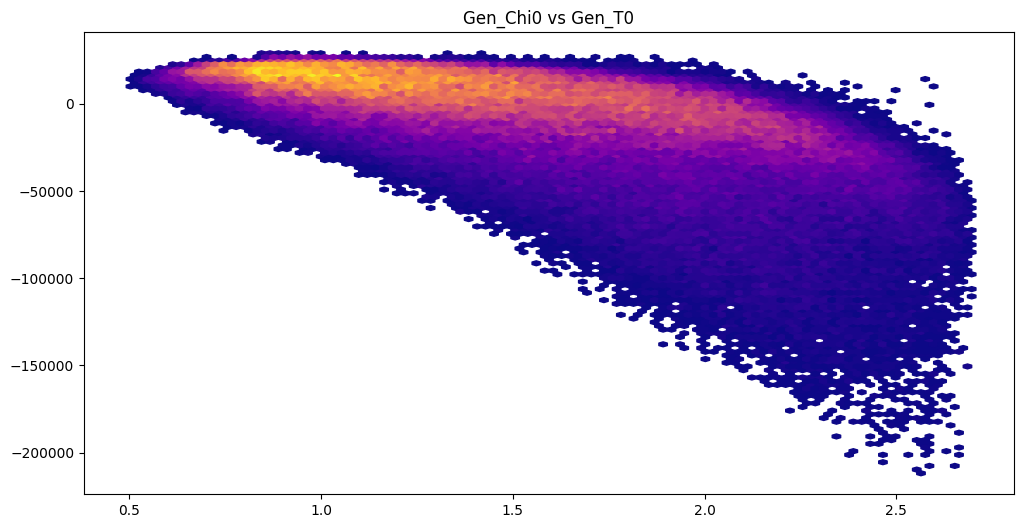

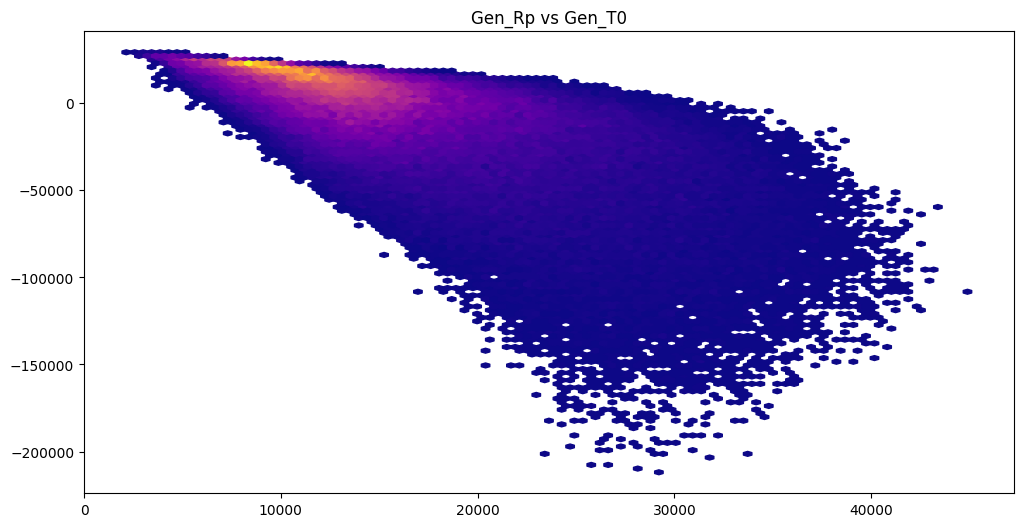

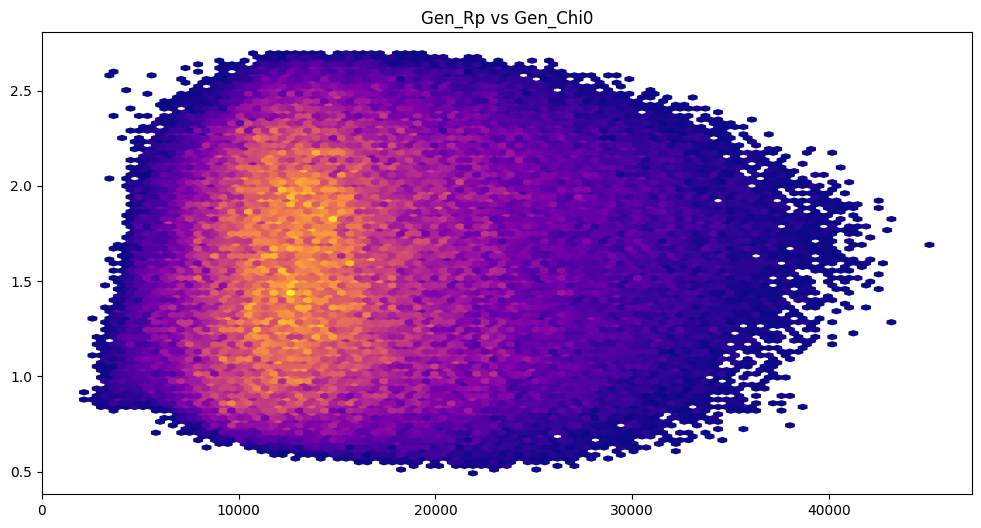

In [223]:
All_T0 = Dataset.get_values('Gen_T0').numpy()
All_Chi0 = Dataset.get_values('Gen_Chi0').numpy()
All_Rp = Dataset.get_values('Gen_Rp').numpy()

plt.figure(figsize=(12,6))
# plt.scatter(All_Chi0, All_T0, s=1, alpha=0.5)
plt.hexbin(All_Chi0, All_T0, gridsize=100, cmap='plasma', mincnt=1)
plt.title('Gen_Chi0 vs Gen_T0')

plt.figure(figsize=(12,6))
plt.hexbin(All_Rp, All_T0, gridsize=100, cmap='plasma', mincnt=1)
plt.title('Gen_Rp vs Gen_T0')

plt.figure(figsize=(12,6))
plt.hexbin(All_Rp, All_Chi0, gridsize=100, cmap='plasma', mincnt=1)
plt.title('Gen_Rp vs Gen_Chi0')